
Goal 1: Goal(question='What is the distribution of Retail_Price across different car Types?', visualization='box plot of Retail_Price grouped by Type', rationale='This visualization will help us understand the price range and variability of retail prices for different types of cars. By using a box plot, we can see the median, quartiles, and potential outliers for each car type, giving a detailed view of price distribution.', index=0)


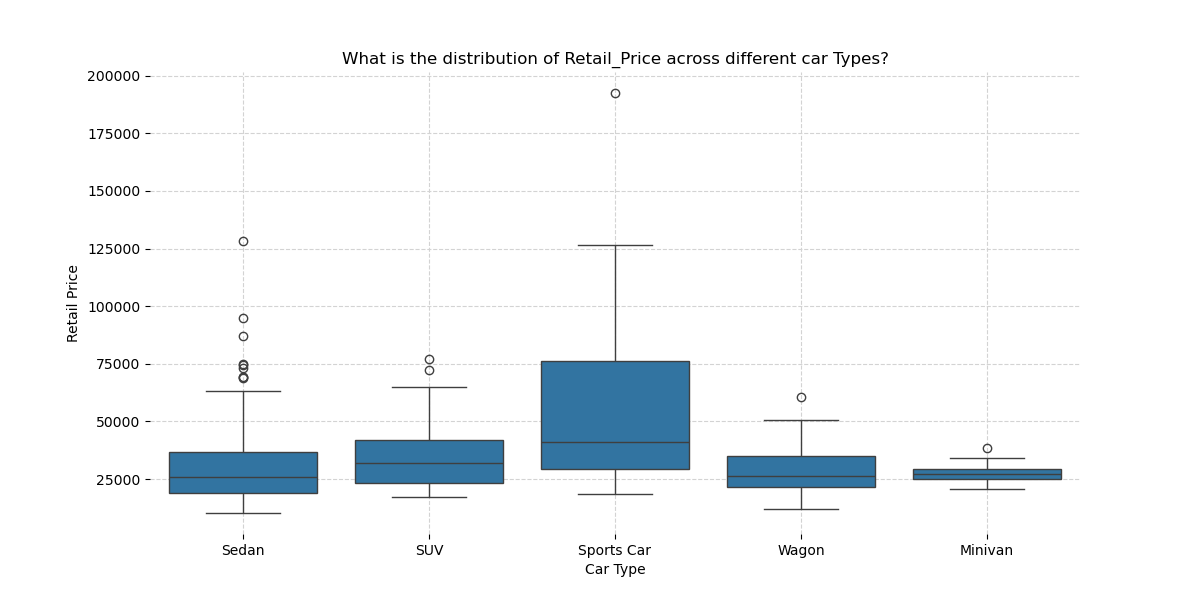


Goal 2: Goal(question='How does Engine_Size__l_ correlate with Horsepower_HP_ across different car Types?', visualization='scatter plot of Engine_Size__l_ vs Horsepower_HP_ with points colored by Type', rationale='This scatter plot will help us understand the relationship between engine size and horsepower for different types of cars. By coloring the points by car type, we can see if certain types of cars tend to have larger engines and higher horsepower, or if the relationship is consistent across all types.', index=1)


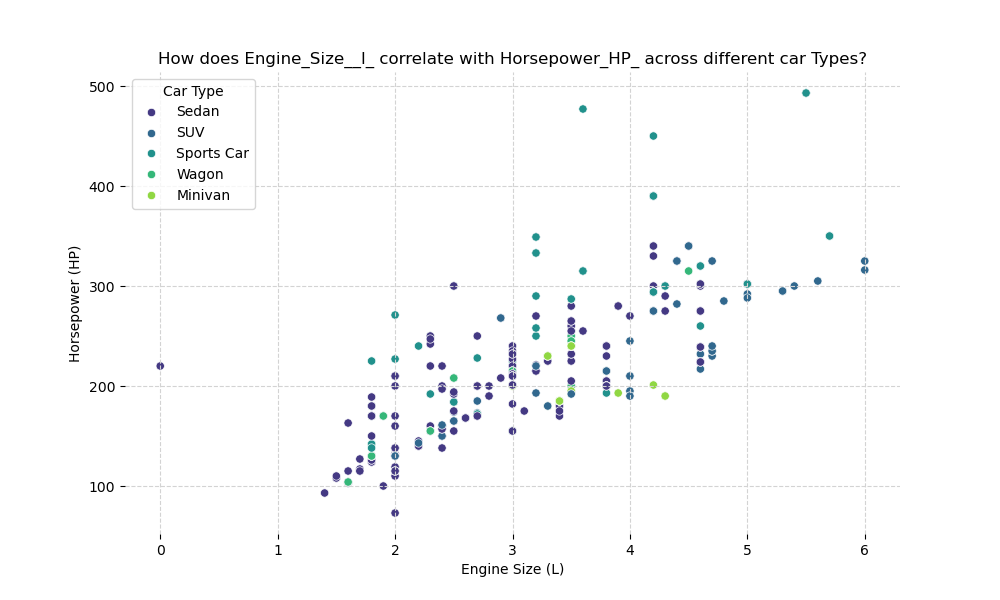


Goal 3: Goal(question='What is the average City_Miles_Per_Gallon and Highway_Miles_Per_Gallon for each car Type?', visualization='grouped bar chart of average City_Miles_Per_Gallon and Highway_Miles_Per_Gallon for each Type', rationale='This grouped bar chart will allow us to compare the fuel efficiency of different car types in both city and highway conditions. By visualizing the average miles per gallon for each type, we can identify which types of cars are more fuel-efficient.', index=2)


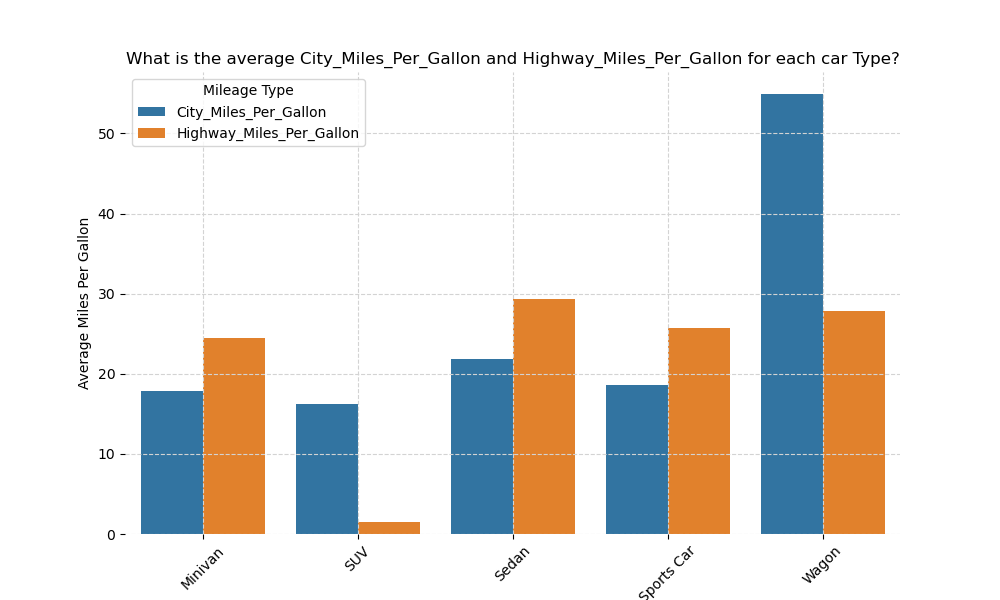


Goal 4: Goal(question='What is the relationship between Weight and City_Miles_Per_Gallon across different car Types?', visualization='scatter plot of Weight vs City_Miles_Per_Gallon with points colored by Type', rationale='This scatter plot will help us understand how the weight of a car affects its fuel efficiency in city driving conditions. By coloring the points by car type, we can see if heavier cars generally have lower miles per gallon and if this trend is consistent across different types of cars.', index=3)


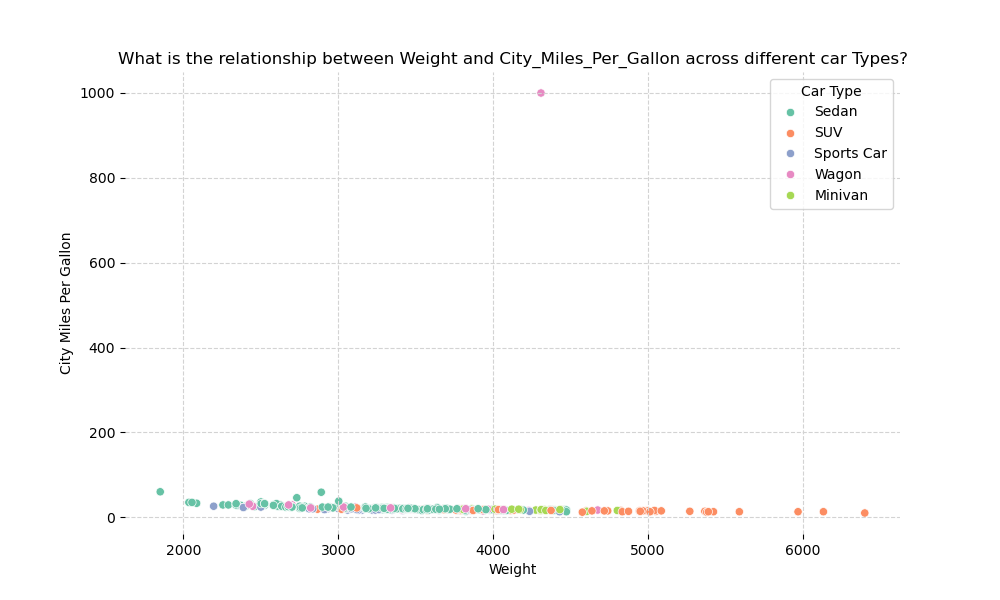

In [2]:
#LIDA 

from lida import Manager, TextGenerationConfig,llm
import os 

API_KEY = "4e08d219725c475a8623f1618397fc2e"
ENDPOINT = "https://lida.openai.azure.com/openai/deployments/college/chat/completions?api-version=2024-02-15-preview"

text_gen = llm(provider="openai", api_type="azure", azure_endpoint = ENDPOINT, api_key = API_KEY ,api_version = "2023-07-01-preview")

lida = Manager(text_gen=text_gen)

textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  

goals = lida.goals(summary, n=4, textgen_config=textgen_config)

library = "seaborn"


for i, goal in enumerate(goals):
    print(f"\nGoal {i + 1}: {goal}") 
    try:
        charts = lida.visualize(summary=summary, goal=goal, textgen_config=textgen_config, library=library)
        if charts:
            display(charts[0]) 
        else:
            print(f"No chart generated for Goal {i + 1}.")
    except Exception as e:
        print(f"Error generating chart for Goal {i + 1}: {e}")

In [ ]:
from lida import Manager, TextGenerationConfig, llm
from langchain.prompts.chat import ChatPromptTemplate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

API_KEY = "4e08d219725c475a8623f1618397fc2e"
ENDPOINT = "https://lida.openai.azure.com/openai/deployments/college/chat/completions?api-version=2024-02-15-preview"

text_gen = llm(
    provider="openai",
    api_type="azure",
    azure_endpoint=ENDPOINT,
    api_key=API_KEY,
    api_version="2023-07-01-preview"
)

lida = Manager(text_gen=text_gen)

textgen_config = TextGenerationConfig(
    n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True
)

df = pd.read_csv("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv")

def automated_graph_generation(goal, data_frame):
    # LLM prompt
    chat_prompt = ChatPromptTemplate.from_template(
        """
        You are a data visualization assistant. Your task is to interpret the user's goal and determine how to visualize the data
        from the dataset to meet the goal. Suggest the most appropriate type of graph, relevant columns, and any other details.

        Dataset Columns: {columns}
        User Goal: {user_goal}

        Return the following as JSON:
        {{
            "graph_type": "type of graph (e.g., bar, line, scatter, etc.)",
            "x_column": "column for the x-axis",
            "y_column": "column for the y-axis (if applicable)",
            "hue_column": "column for coloring or grouping (if applicable, otherwise null)",
            "additional_notes": "any other relevant details"
        }}
        """
    )


    formatted_prompt = chat_prompt.format_messages(
        user_goal=goal,
        columns=", ".join(data_frame.columns)
    )[0].content

    messages = [{"role": "system", "content": formatted_prompt}]

    try:
        response = text_gen.generate(messages, textgen_config)

        if response and hasattr(response, 'text'):
            print("LLM Response Text:", response.text.strip())  # Access text directly
        else:
            print("No response or invalid response received.")
            return

        try:
            cleaned_content = response.text.strip().strip("```").strip()
            graph_config = json.loads(cleaned_content)
            print("Parsed Graph Config:", graph_config)
        except json.JSONDecodeError as e:
            print("Error parsing LLM response:", e)
            return

        graph_type = graph_config.get("graph_type", "").lower()
        if graph_type not in ["bar", "line", "scatter"]:
            print(f"Graph type '{graph_type}' is not supported.")
            return
        
        x_column = graph_config.get("x_column")
        y_column = graph_config.get("y_column")
        hue_column = graph_config.get("hue_column")

        if not x_column or not y_column:
            print("Missing necessary columns for graph generation.")
            return

        if graph_type == "bar":
            plt.figure(figsize=(10, 6))
            sns.barplot(data=data_frame, x=x_column, y=y_column, hue=hue_column)
            plt.title(f"Bar Chart: {graph_config.get('additional_notes', '')}")
            plt.show()
        elif graph_type == "line":
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=data_frame, x=x_column, y=y_column, hue=hue_column)
            plt.title(f"Line Chart: {graph_config.get('additional_notes', '')}")
            plt.show()
        elif graph_type == "scatter":
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=data_frame, x=x_column, y=y_column, hue=hue_column)
            plt.title(f"Scatter Plot: {graph_config.get('additional_notes', '')}")
            plt.show()

    except Exception as e:
        print(f"Error generating response: {e}")


summary = lida.summarize(
    df,
    summary_method="default",
    textgen_config=textgen_config
)

goals = lida.goals(summary, n=4, textgen_config=textgen_config)
print("\nGenerated Goals:")
for goal in goals:
    print("-", goal)

for goal in goals:
    print(f"\nProcessing Goal: {goal}")
    automated_graph_generation(goal, df)


In [ ]:
from langchain_experimental.agents import create_csv_agent
from langchain.llms import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
from langchain.chat_models import AzureChatOpenAI
%matplotlib inline

API_KEY = "4e08d219725c475a8623f1618397fc2e"
ENDPOINT = "https://lida.openai.azure.com/openai/deployments/college/chat/completions?api-version=2024-02-15-preview"
DEPLOYMENT_NAME = "college"

df = pd.read_csv("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv")
url = "https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv"

llm = AzureChatOpenAI(
    openai_api_base=ENDPOINT,
    openai_api_key=API_KEY,
    deployment_name=DEPLOYMENT_NAME,
    openai_api_version="2024-02-15-preview",
)
agent = create_csv_agent(llm, url, allow_dangerous_code=True,max_iterations=10, verbose=True)
user_prompt = input("Enter your prompt: ")
try:
    response = agent.run(user_prompt)
    
    print("Agent response:")
    print(response)
    
    if "```python" in response:
        code_start = response.find("```python") + len("```python")
        code_end = response.find("```", code_start)
        code = response[code_start:code_end].strip()
        print("\nExtracted code:")
        print(code)
        
        print("\nExecuting the extracted code...\n")
        exec(code)
    else:
        print("No executable Python code found in the response.")

except Exception as e:
    print(f"An error occurred: {e}")